In [1]:
! pip install --quiet "torchmetrics>=0.3" "matplotlib" "torch>=1.6, <1.9" "pytorch-lightning>=1.3"

     |████████████████████████████████| 397 kB 30.8 MB/s 
     |████████████████████████████████| 804.1 MB 2.6 kB/s 
     |████████████████████████████████| 527 kB 74.8 MB/s 
     |████████████████████████████████| 829 kB 65.6 MB/s 
     |████████████████████████████████| 596 kB 62.3 MB/s 
     |████████████████████████████████| 134 kB 67.6 MB/s 
     |████████████████████████████████| 952 kB 35.6 MB/s 
     |████████████████████████████████| 1.1 MB 44.6 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
     |████████████████████████████████| 144 kB 70.5 MB/s 
     |████████████████████████████████| 271 kB 69.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.8.1 which is incompatible

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as TUD

from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgba
from tqdm.notebook import tqdm

set_matplotlib_formats("svg", "pdf")

In [3]:
torch.__version__

'1.8.1+cu102'

In [4]:
torch.manual_seed(42)  # Setting the seed

In [5]:
x = torch.arange(6)
x = x.view(2, 3)
print("X", x)

X tensor([[0, 1, 2],
        [3, 4, 5]])


In [6]:
W = torch.arange(9).view(3, 3)  # We can also stack multiple operations in a single line
print("W", W)

W tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])


In [7]:
h = torch.matmul(x, W)
print("h", h)

h tensor([[15, 18, 21],
        [42, 54, 66]])


In [8]:
x = torch.ones((3,))
print(x.requires_grad)

False


In [9]:
x.requires_grad_(True)
print(x.requires_grad)

True


In [10]:
x = torch.arange(3, dtype=torch.float32, requires_grad=True)  # Only float tensors can have gradients
print("X", x)

X tensor([0., 1., 2.], requires_grad=True)


In [11]:
a = x + 2
b = a ** 2
c = b + 3
y = c.mean()
print("Y", y)

Y tensor(12.6667, grad_fn=<MeanBackward0>)


In [12]:
y.backward()

In [13]:
x.grad

tensor([1.3333, 2.0000, 2.6667])

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [15]:
x = torch.randn(5000, 5000)

# CPU version
start_time = time.time()
_ = torch.matmul(x, x)
end_time = time.time()
print(f"CPU time: {(end_time - start_time):6.5f}s")

# GPU version
if torch.cuda.is_available():
    x = x.to(device)
    # CUDA is asynchronous, so we need to use different timing functions
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    _ = torch.matmul(x, x)
    end.record()
    torch.cuda.synchronize()  # Waits for everything to finish running on the GPU
    print(f"GPU time: {0.001 * start.elapsed_time(end):6.5f}s")  # Milliseconds to seconds

CPU time: 3.16387s
GPU time: 0.08905s


In [16]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [17]:
import torch.nn.functional as F

In [18]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        # Some init for my module

    def forward(self, x):
        # Function for performing the calculation of the module.
        pass

In [19]:
class SimpleClassifier(nn.Module):
  def __init__(self, num_inputs, num_hidden, num_outputs):
    super().__init__()
    self.linear1 = nn.Linear(num_inputs, num_hidden)
    self.act_fn = nn.Tanh()
    self.linear2 = nn.Linear(num_hidden, num_outputs)
  
  def forward(self, x):
    x = self.linear1(x)
    x = self.act_fn(x)
    x = self.linear2(x)
    return x

In [20]:
model = SimpleClassifier(2, 4, 1)
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [21]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


In [22]:
class XORDataset(TUD.Dataset):
  def __init__(self, size, std=0.1):
    """
    Inputs:
      size - Number of data points we want to generate
      std - Standard deviation of the noise (see generate_continuous_xor function)
    """
    super().__init__()
    self.size = size
    self.std = std
    self.generate_continuous_xor()
  

  def generate_continuous_xor(self):
    # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
    # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
    # If x=y, the label is 0.

    data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
    label = (data.sum(dim=1) == 1).to(torch.long)
    # To make it slightly more challenging, we add a bit of gaussian noise to the data points.

    data += self.std * torch.randn(data.shape)

    self.data = data
    self.label = label
  

  def __len__(self):
    return self.size
  

  def __getitem__(self, index):
      data_point = self.data[index]
      data_label = self.label[index]
      return data_point, data_label

In [23]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([1.0275, 0.0544]), tensor(1))


In [24]:
import seaborn as sns

In [25]:
def visualize_samples(data, label):
  if isinstance(data, torch.Tensor):
    data = data.cpu().numpy()
  if isinstance(label, torch.Tensor):
    label = label.cpu().numpy()

  sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=label)
    

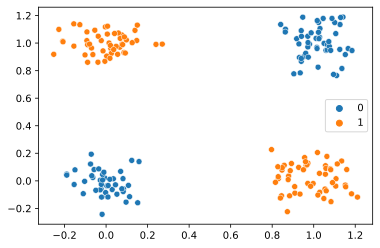

In [26]:
visualize_samples(dataset.data, dataset.label)

In [27]:
data_loader = TUD.DataLoader(dataset, batch_size=8, shuffle=True) 

The class torch.utils.data.DataLoader represents a Python iterable over a dataset with support for automatic batching, multi-process data loading and many more features. The data loader communicates with the dataset using the function __getitem__, and stacks its outputs as tensors over the first dimension to form a batch. In contrast to the dataset class, we usually don’t have to define our own data loader class, but can just create an object of it with the dataset as input. 

In [28]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[ 1.0211,  0.8252],
        [ 0.1587,  0.1399],
        [ 1.1297,  1.1860],
        [ 0.0593,  1.0735],
        [ 0.9739,  0.8980],
        [ 0.0226,  0.9619],
        [ 0.2403,  0.9906],
        [ 0.9341, -0.0960]])
Data labels torch.Size([8]) 
 tensor([0, 0, 0, 1, 0, 1, 1, 1])


In [29]:
loss_module = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [30]:
train_dataset = XORDataset(size=1000)
train_data_loader = TUD.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [31]:
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [32]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train()

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:

            # Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            # Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)  # Output is [Batch size, 1], but we want [Batch size]

            # Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            # Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            # Step 5: Update the parameters
            optimizer.step()

In [33]:
train_model(model, optimizer, train_data_loader, loss_module)

  0%|          | 0/100 [00:00<?, ?it/s]

In [34]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[-0.3586, -0.4029],
        [-2.6447, -2.6702],
        [-1.4792, -1.3036],
        [ 0.1347, -0.6538]], device='cuda:0')), ('linear1.bias', tensor([-0.0310,  1.0750,  2.0364, -0.7691], device='cuda:0')), ('linear2.weight', tensor([[ 0.7838, -3.2562,  2.6642,  1.3423]], device='cuda:0')), ('linear2.bias', tensor([-1.3138], device='cuda:0'))])


In [35]:
# torch.save(object, filename). For the filename, any extension can be used
torch.save(state_dict, "our_model.tar")

In [36]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("our_model.tar")

# Create a new model and load the state
new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)

# Verify that the parameters are the same
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict([('linear1.weight', tensor([[-0.3586, -0.4029],
        [-2.6447, -2.6702],
        [-1.4792, -1.3036],
        [ 0.1347, -0.6538]], device='cuda:0')), ('linear1.bias', tensor([-0.0310,  1.0750,  2.0364, -0.7691], device='cuda:0')), ('linear2.weight', tensor([[ 0.7838, -3.2562,  2.6642,  1.3423]], device='cuda:0')), ('linear2.bias', tensor([-1.3138], device='cuda:0'))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[-0.3586, -0.4029],
        [-2.6447, -2.6702],
        [-1.4792, -1.3036],
        [ 0.1347, -0.6538]])), ('linear1.bias', tensor([-0.0310,  1.0750,  2.0364, -0.7691])), ('linear2.weight', tensor([[ 0.7838, -3.2562,  2.6642,  1.3423]])), ('linear2.bias', tensor([-1.3138]))])


In [38]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = TUD.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [39]:
def eval_model(model, data_loader):
    model.eval()  # Set model to eval mode
    true_preds, num_preds = 0.0, 0.0

    with torch.no_grad():  # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds)  # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long()  # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [40]:
eval_model(model, test_data_loader)

Accuracy of the model: 99.80%


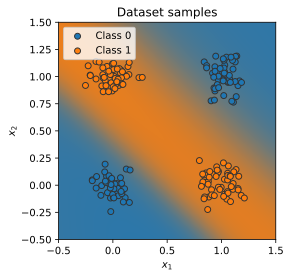

In [41]:
@torch.no_grad()  # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    # Specifying "None" in a dimension creates a new one
    output_image = (1 - preds) * c0[None, None] + preds * c1[None, None]
    output_image = (
        output_image.cpu().numpy()
    )  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin="lower", extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)


visualize_classification(model, dataset.data, dataset.label)
plt.show()